#### <h1> Time Series Analysis and Forecasting</h1>


In [1]:
import pandas as pd #if you need other libraries, import them!
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs
from matplotlib.widgets import Slider
from scipy.stats import trim_mean
from scipy.stats import norm
from scipy.stats import normaltest
from scipy.stats import probplot
#note the new methods imported from the statsmodels package
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller #stationarity test
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
import warnings

In [2]:
df = pd.read_csv('air-travel2.csv') #read file into a dataframe 

In [82]:
df.head(1) 

,Passenger Count
Date,
2005-07-01,14.266212
2005-08-01,14.255793
2005-09-01,14.125301
2005-10-01,14.141082
2005-11-01,14.081279
...,...
2013-06-01,14.553651
2013-07-01,14.538245
2013-08-01,14.583224


In [4]:
df_2 = df[["Date","Passenger Count"]] ; df_2

,Date,Passenger Count
0,2005-07,29131
1,2005-07,34090
2,2005-07,5500
3,2005-07,11638
4,2005-07,4962
...,...,...
10593,2020-06,10522
10594,2020-06,50628
10595,2020-06,2991
10596,2020-06,1352


In [5]:
df_21 = df_2 # used for later on 

In [6]:
df_2['Date']=pd.to_datetime(df_2['Date']);df_2.head() # add a day to the date

<ipython-input-6-e57287c06bde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Date']=pd.to_datetime(df_2['Date']);df_2.head() # add a day to the date


,Date,Passenger Count
0,2005-07-01,29131
1,2005-07-01,34090
2,2005-07-01,5500
3,2005-07-01,11638
4,2005-07-01,4962


In [7]:
df_2 = df_2.loc[df_2["Date"]<="2020-02"] # create a new df which data from feb 2020 and before

In [8]:
df_2

,Date,Passenger Count
0,2005-07-01,29131
1,2005-07-01,34090
2,2005-07-01,5500
3,2005-07-01,11638
4,2005-07-01,4962
...,...,...
10436,2020-02-01,1953
10437,2020-02-01,6468
10438,2020-02-01,11004
10439,2020-02-01,6497


In [9]:
df_3 = pd.DataFrame(df_2.groupby("Date")["Passenger Count"].sum())

In [10]:
df_3.dtypes

Passenger Count    int64
dtype: object

In [11]:
df_3

,Passenger Count
Date,
2005-07-01,1569412
2005-08-01,1553146
2005-09-01,1363140
2005-10-01,1384822
2005-11-01,1304433
...,...
2019-10-01,2425539
2019-11-01,2235301
2019-12-01,2401871


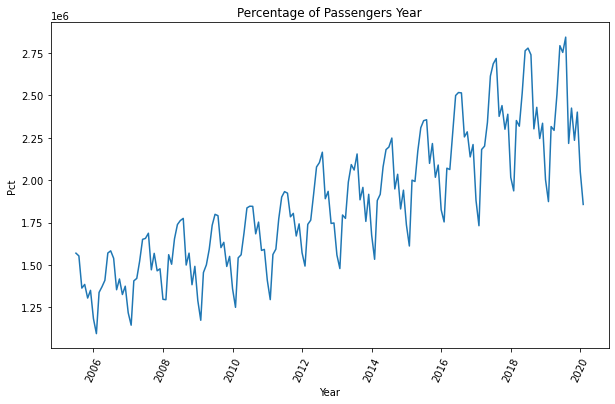

In [12]:
counts = df_3['Passenger Count']
plt.figure(figsize=(10,6))
plt.xticks(rotation = 65)
plt.plot(df_3.index, df_3['Passenger Count'])
plt.title('Percentage of Passengers Year')
plt.xlabel('Year')
plt.ylabel('Pct');

<div class="alert alert-block alert-warning">
So I created a time plot with each number of passengers within each month from year January 2005 to Febuary 2020.
</div>

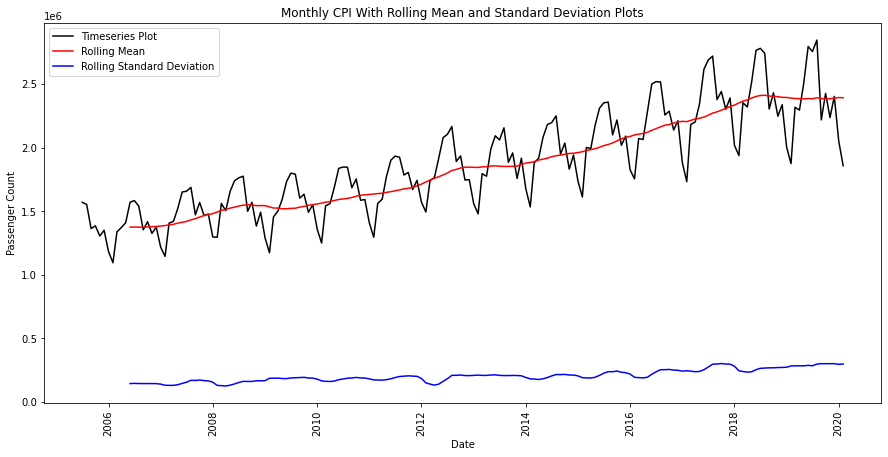

In [13]:
rolling_mean = df_3['Passenger Count'].rolling(12).mean()
rolling_SD = df_3['Passenger Count'].rolling(window = 12).std()
    
plt.figure(figsize=(15,7))
plt.xticks(rotation = 90)
plt.plot(df_3.index,df_3['Passenger Count'], label='Timeseries Plot',color="black")
plt.plot(df_3.index,rolling_mean, color= "red", label= 'Rolling Mean')
plt.plot(df_3.index,rolling_SD, color= "blue", label= 'Rolling Standard Deviation')   
plt.title('Monthly CPI With Rolling Mean and Standard Deviation Plots')

plt.xlabel('Date')
plt.ylabel('Passenger Count') 


plt.legend();

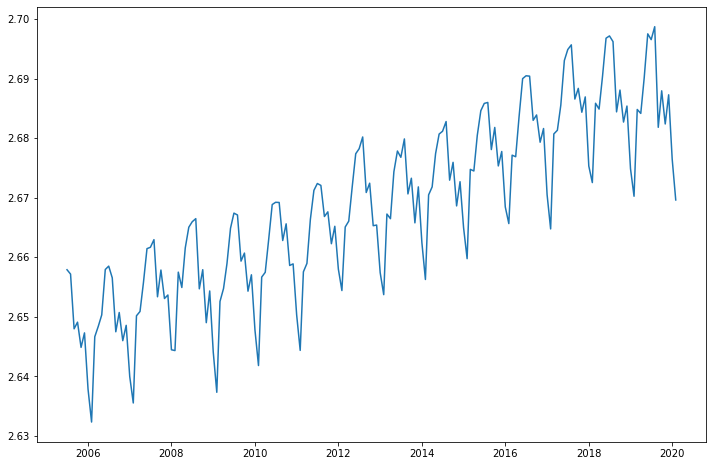

In [14]:
plt.figure(figsize=(12,8))
df_3["Passenger Count"] = np.log(df_3['Passenger Count'])
plt.plot(np.log(df_3['Passenger Count']));

In [15]:
def test_stationarity(timeseries):
    print('Augmented Dickey-Fuller Test Summary')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Statistic', 'p-value', 'No. Periods Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)    

In [16]:
test_stationarity(df_3['Passenger Count'])

Augmented Dickey-Fuller Test Summary
Statistic                       -1.334929
p-value                          0.613045
No. Periods Used                14.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


<div class="alert alert-block alert-warning">
Our ADF test shows that our p-value is greater that 0.05 and also our statistic test is bigger that our Critical Value (10%) or any other values displayed. We cannot reject the null hypothesis. We must conclude that our times series process is in fact non stationary.
</div>

In [17]:
df_3['diff']=df_3['Passenger Count'].diff();

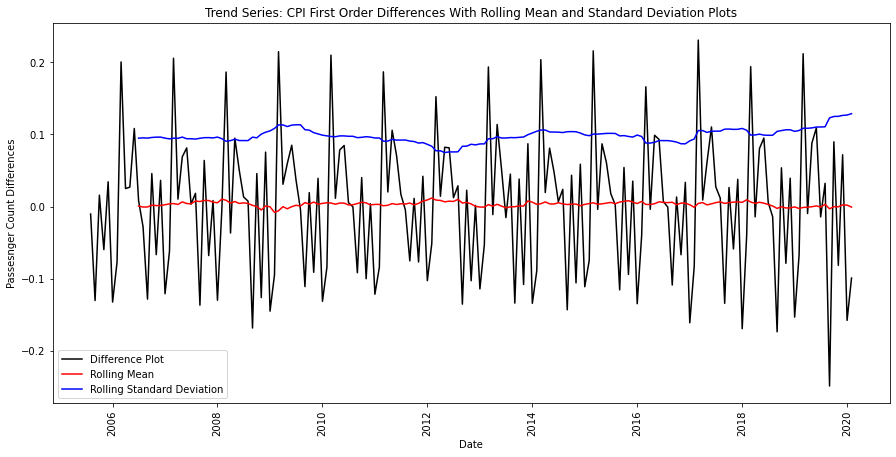

In [18]:
rolling_mean = df_3['diff'].rolling(12).mean()
rolling_SD = df_3['diff'].rolling(window = 12).std()
    
plt.figure(figsize=(15,7))
plt.xticks(rotation = 90)
plt.plot(df_3.index,df_3['diff'], label='Difference Plot',color="black")
plt.plot(df_3.index,rolling_mean, color= "red", label= 'Rolling Mean')
plt.plot(df_3.index,rolling_SD, color= "blue", label= 'Rolling Standard Deviation')   
plt.title('Trend Series: CPI First Order Differences With Rolling Mean and Standard Deviation Plots')

plt.xlabel('Date')
plt.ylabel('Passesnger Count Differences') 
plt.legend();

In [19]:
test_stationarity(df_3['diff'].dropna()) # test ADF

Augmented Dickey-Fuller Test Summary
Statistic                       -2.947846
p-value                          0.040060
No. Periods Used                13.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


<div class="alert alert-block alert-warning">
When we differenced our times series we then get on our ADF test that the p-value is less than our mark of 0.05. We also have that our statistic test is smaller than both our 5% and 10% Critical Values. With this information we are able to reject the null hypthesis and conclude that are time series process is in fact stationary. 
</div>

In [20]:
df_3['seas_diff']=df_3['Passenger Count'].diff(12);df_3.head(15)

,Passenger Count,diff,seas_diff
Date,,,
2005-07-01,14.266212,NaN,NaN
2005-08-01,14.255793,-0.010418,NaN
2005-09-01,14.125301,-0.130492,NaN
2005-10-01,14.141082,0.015781,NaN
2005-11-01,14.081279,-0.059803,NaN
2005-12-01,14.115615,0.034336,NaN
2006-01-01,13.982983,-0.132632,NaN
2006-02-01,13.905781,-0.077202,NaN
2006-03-01,14.106515,0.200734,NaN


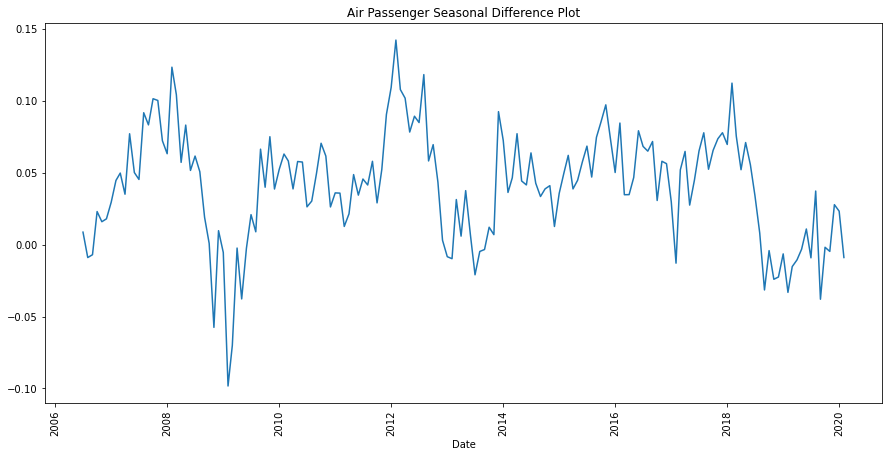

In [21]:
plt.figure(figsize=(15,7))
plt.xticks(rotation = 90)

plt.plot(df_3.index,df_3['seas_diff'])

plt.xlabel('Date')
plt.title('Air Passenger Seasonal Difference Plot');

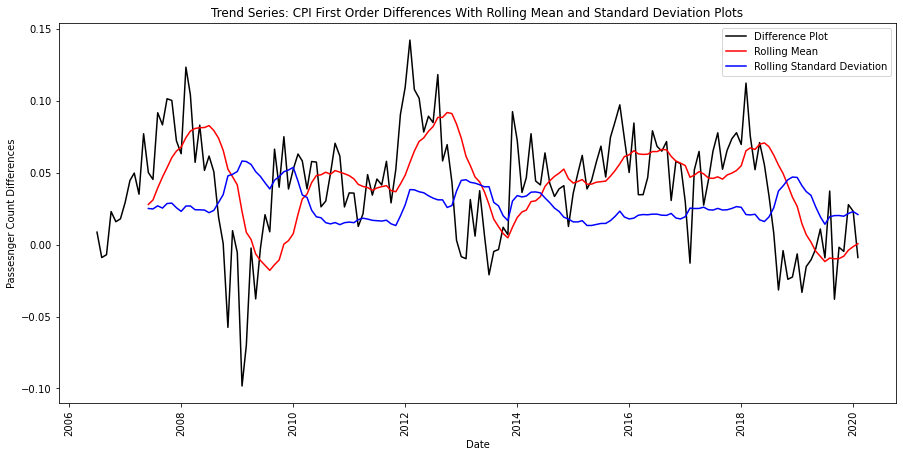

In [22]:
rolling_mean = df_3['seas_diff'].rolling(12).mean()
rolling_SD = df_3['seas_diff'].rolling(window = 12).std()
    
plt.figure(figsize=(15,7))
plt.xticks(rotation = 90)
plt.plot(df_3.index,df_3['seas_diff'], label='Difference Plot',color="black")
plt.plot(df_3.index,rolling_mean, color= "red", label= 'Rolling Mean')
plt.plot(df_3.index,rolling_SD, color= "blue", label= 'Rolling Standard Deviation')   
plt.title('Trend Series: CPI First Order Differences With Rolling Mean and Standard Deviation Plots')

plt.xlabel('Date')
plt.ylabel('Passesnger Count Differences') 
plt.legend();

In [23]:
test_stationarity(df_3['seas_diff'].dropna())

Augmented Dickey-Fuller Test Summary
Statistic                       -2.516659
p-value                          0.111473
No. Periods Used                13.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


<div class="alert alert-block alert-warning">
Though our differenced times series is in fact stationary, I still decided to apply a seasonal differenced to see if we could get that p-value smaller than it is. The ADF test shows that are p-value did get extremely smaller which the number being 0.003 compared to our differenced p-value which was 0.04. Also our statistic test shows it value is less than all critical values instead of just 5% and the 10% values like in our differenced series, which mean we can reject the null hypothesis and declare this time series process stationary.
</div>

In [24]:
def acfpacf(y, name,lags=None, figsize=(12, 7)):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
          
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    if (p_value < 0.05):
        ts_type = 'Stationary'
    else:
        ts_type = 'Non-Stationary'
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: '+ ts_type +"\n"+ name)
    plot_acf(y, lags=lags, ax=acf_ax,zero=False)
    plot_pacf(y, lags=lags, ax=pacf_ax,zero=False)
    plt.tight_layout()

/Users/dariushammond/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


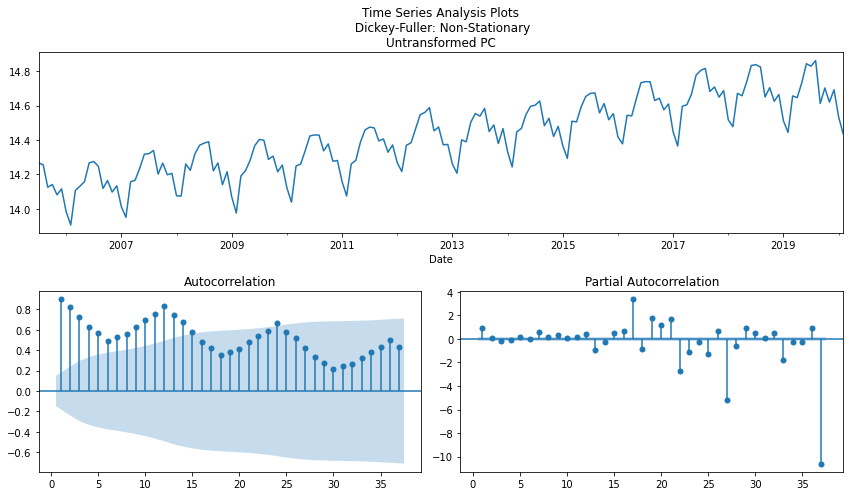

In [25]:
acfpacf(df_3["Passenger Count"],'Untransformed PC', lags=37);

/Users/dariushammond/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


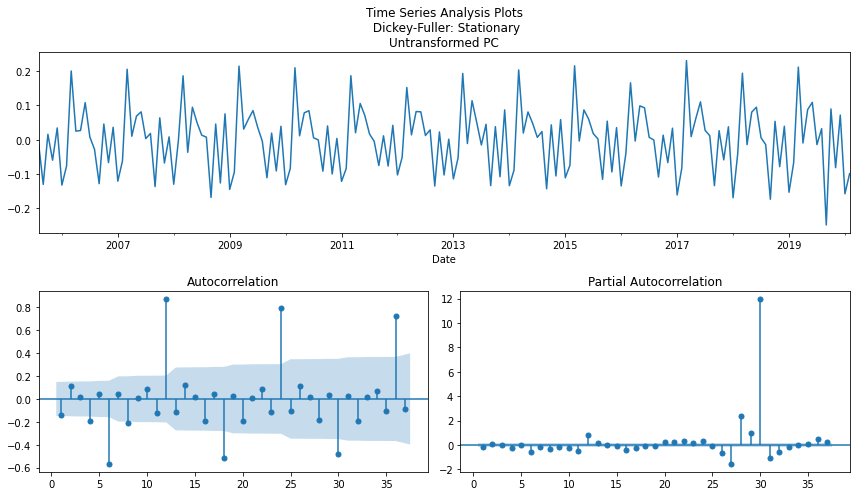

In [26]:
acfpacf(df_3["diff"].dropna(),'Untransformed PC', lags=37);

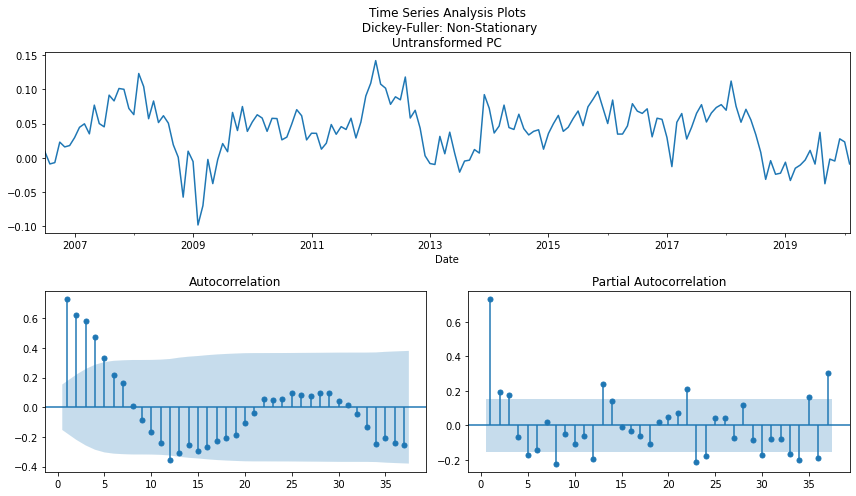

In [27]:
acfpacf(df_3["seas_diff"].dropna(),'Untransformed PC', lags=37);

<div class="alert alert-block alert-warning">
Our AFC and PACF graphs above show that there is seasonality and also gives us a clear view that this is a AR(2)by looking at our PACF for seasonal differencing. So are parameters should be (2,1,0)x(0,1,0)12. Our "p" being 2, "d" being 1,"q" being 0,"P" being 0, "D" being 1, and our "Q" being 0.
</div>

In [28]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs

In [29]:
n_diffs = ndiffs(df_3['Passenger Count'], max_d=6)

print("Estimated differencing term (d): ", n_diffs)

Estimated differencing term (d):  1


In [30]:
n_sdiffs = nsdiffs(df_3['Passenger Count'], m=12)

print("Estimated seasonal differencing term (D): ",n_sdiffs)

Estimated seasonal differencing term (D):  1


In [31]:
auto_df_3_model = pm.auto_arima(df_3['Passenger Count'], d=n_diffs, seasonal=True, m=12,stepwise=True,
                     suppress_warnings=True, error_action="ignore", D=n_sdiffs, max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-753.055, Time=0.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-697.253, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-731.709, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-756.108, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-717.151, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-756.543, Time=0.94 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-754.921, Time=1.27 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-732.378, Time=0.93 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-754.956, Time=1.29 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=-755.151, Time=1.08 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-747.752, Time=0.78 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=-753.320, Time=1.14 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=-754.621, Time=1.16 sec

Best model:  ARIMA(0,1,

<div class="alert alert-block alert-warning">
As we can see by using our Auto Arima seasonal model, The estimated differencing is estimated at 1 and also our seasonal differencing is estimated at 1 like we predicted, but the "p","q"and "Q" I predicted is incorrect.
</div>

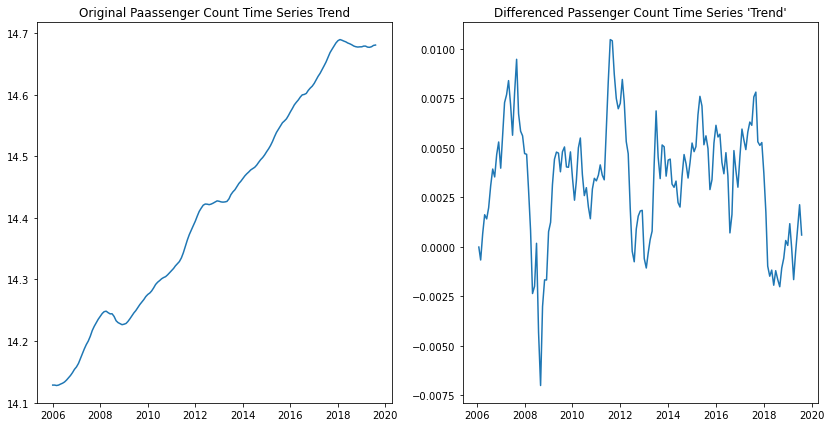

In [32]:
plt.rcParams["figure.figsize"] = [14,7]
fig,(ax1, ax2) = plt.subplots(1, 2)

ax1.plot(seasonal_decompose(df_3['Passenger Count']).trend)
ax2.plot(seasonal_decompose(df_3['diff'].dropna()).trend)
ax1.title.set_text('Original Paassenger Count Time Series Trend')
ax2.title.set_text("Differenced Passenger Count Time Series 'Trend'")

In [33]:
df_3["diff"].mean()

0.0009612990239557462

In [34]:
warnings.filterwarnings('ignore')
trend = ['n','c','t','ct']
for t in trend:
    result = SARIMAX(df_3['Passenger Count'],order=(0,1,0),seasonal_order=(0,0,0,0),trend=t).fit()
    print('trend: '+t,'AIC: ',result.aic,'AICc: ',result.aicc,'BIC: ',result.bic)



trend: n AIC:  -323.2338517919152 AICc:  -323.21073040463193 BIC:  -320.06906581799166
trend: c AIC:  -321.25156849603303 AICc:  -321.1818010541726 BIC:  -314.92199654818603
trend: t AIC:  -321.2344612593224 AICc:  -321.16469381746197 BIC:  -314.90488931147536
trend: ct AIC:  -319.2848000585485 AICc:  -319.1444491813555 BIC:  -309.790442136778


In [35]:
PC_result_SAR = SARIMAX(df_3['Passenger Count'],order=(0,1,1),seasonal_order=(0,0,0,0),trend='n').fit()


In [36]:
print(PC_result_SAR.summary())

                               SARIMAX Results                                
Dep. Variable:        Passenger Count   No. Observations:                  176
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 164.132
Date:                Tue, 27 Apr 2021   AIC                           -324.264
Time:                        21:58:00   BIC                           -317.935
Sample:                    07-01-2005   HQIC                          -321.697
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1198      0.112     -1.074      0.283      -0.339       0.099
sigma2         0.0090      0.001      6.712      0.000       0.006       0.012
Ljung-Box (L1) (Q):                   0.04   Jarque-

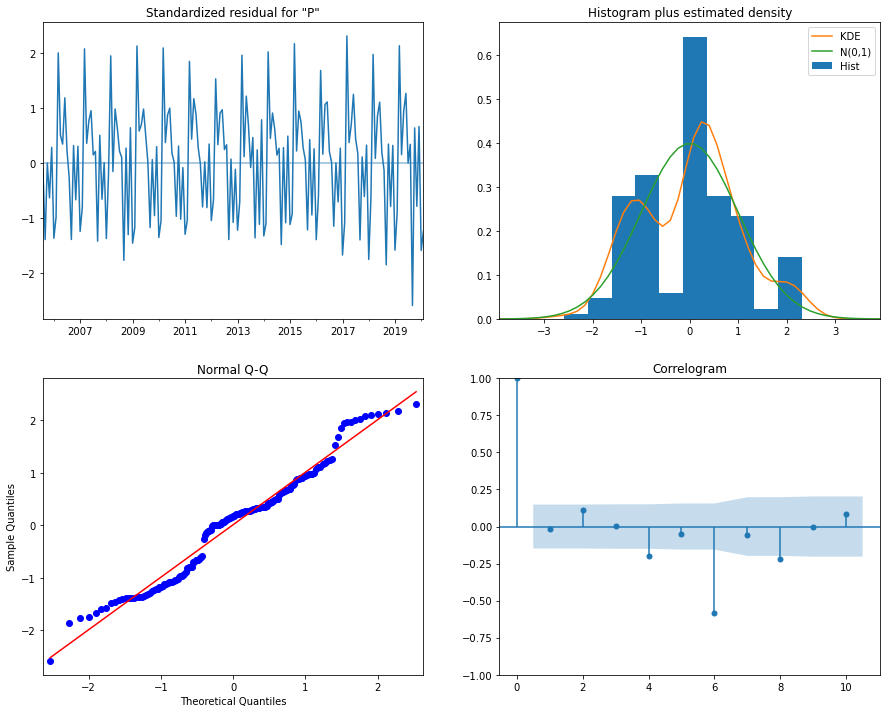

In [37]:
PC_SAR_resid = PC_result_SAR.resid
PC_SAR_resid.drop(pd.Timestamp('2005-07-01'),inplace=True);#dropping that odd first value
PC_result_SAR.plot_diagnostics(figsize=(15, 12));

In [38]:
def sarima_parameter_search(p_range, d_range, q_range,P_range,D_range,Q_range, seasonal = [12]):
#Generate all of the parameter combinations for a SARIMA model given input ranges.
    p = range(0, p_range+1)
    d = range(0, d_range+1)
    q = range(0, q_range+1)
    P = range(0, P_range+1)
    D = range(0, D_range+1)
    Q = range(0, Q_range+1) 
    trend = ['n','c','t','ct']
    #list of all non-seasonal parameter possibilities
    pdq = list(itertools.product(p, d, q))
    #list of all seasonal parameter possibilities, including trend as the last component
    seasonal_pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(P, D, Q, seasonal, trend))]
    return pdq, seasonal_pdq_combinations

In [39]:
def seasonal_arima_model(time_series, order, seasonal_order, trend):
#Generate a seasonal ARIMA model using a set of parameters
    try:
        model = SARIMAX(time_series, 
                        order=order, 
                        seasonal_order=seasonal_order, 
                        trend = trend,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        model_fit = model.fit()
        #the following can be uncommented 
        #but uncommenting will significanly increase computation time when function is called in the grid search
        #Print the model results
        #print('ARIMA{}x{} - AIC:{} - Trend:{}'.format(order, seasonal_order, model_fit.aic,trend))
        #print(model_fit.summary())
        
        return model_fit, model_fit.aic, model_fit.bic
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

<div class="alert alert-block alert-warning">
Now lets do a residual check since we have the parameters. The residual check is a function that provides a check for all the criterias needed. The first two required criterias are the mean of the residuals and the status of are residuals being uncorrelated or not. There are two other criterias, but are not required which is the Normality test and the stationary test.
</div>

In [40]:
#this function is a residual diagnostics tool that analyses residual data that is available when a model is created
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from scipy.stats import jarque_bera as jb
import numpy as np


def residcheck(residuals, lags):
    
    #If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    print("Residuals should be uncorrelated with zero mean, have constant variance and are approximately normally distributed.\n")
    
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(12,10))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0));
    pb_ax = plt.subplot2grid(layout, (1,0));
    acf_ax = plt.subplot2grid(layout, (1, 1));
    kde_ax = plt.subplot2grid(layout, (0, 1));
    
    ts_ax.set_title('Residuals')
    kde_ax.set_title('kde and pdf')

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    #sb.kdeplot(residuals);
    sb.histplot(data=residuals, kde=True,stat="density",ax=kde_ax)
    mu, std = norm.fit(residuals)                               

    # calculate pdf 
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)                                                 
    y_pdf = norm.pdf(x,mu,std)
    # and plot on the same axes that seaborn put the histogram
    kde_ax.plot(x, y_pdf, 'r', lw=2,label="Normal")    
    kde_ax.legend()
    probplot(residuals, dist="norm", plot=pb_ax)
    
    sb.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    if len(residuals)<2000:
        print("\n** Sample too small for Jarque Bera Normality Test (< 2000)")
    else:    
        print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, pb_ax, acf_ax, kde_ax

Residuals should be uncorrelated with zero mean, have constant variance and are approximately normally distributed.

** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.142 (>0.05, Uncorrelated)

** Sample too small for Jarque Bera Normality Test (< 2000)

** AD Fuller, p_value: 0.559 (>0.05, Non-stationary)


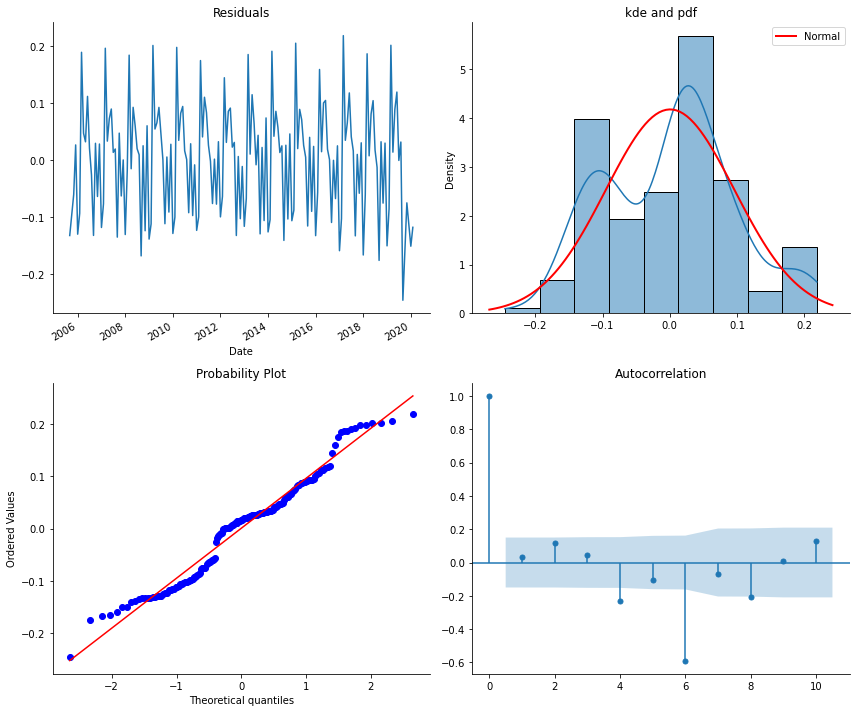

In [41]:
PC_SAR_resid = PC_result_SAR.resid
PC_SAR_resid.drop(pd.Timestamp('2005-07-01'),inplace=True);
PC_SAR_resid.drop(pd.Timestamp('2005-08-01'),inplace=True);
PC_SAR_resid.drop(pd.Timestamp('2005-10-01'),inplace=True);
PC_SAR_resid.drop(pd.Timestamp('2019-10-01'),inplace=True);
PC_SAR_resid.drop(pd.Timestamp('2019-12-01'),inplace=True);
residcheck(PC_SAR_resid,lags=10);#use lags=10 to sync with plot_diagnostics method

<div class="alert alert-block alert-warning">
The results of our residual diagnostics look fairly good for our model. The residuals have the required mean of zero and are uncorrelated. They also have the optional constant variance and are normally distributed.
</div>

In [42]:
%%time
order_combos, seasonal_order_combos = sarima_parameter_search(0,1,1,0,1,2)
    
lowest_aic_val = 100000000000
    #Generate  model for each of hyperparameter combination in a loop
for order_combo in order_combos:
    for seasonal_order_combo in seasonal_order_combos:
        #Convert the combination to list format
        seasonal_order_combo = list(seasonal_order_combo)
        #Generate the SARIMA model
        model_fit, model_aic, model_bic = seasonal_arima_model(time_series = df_3['Passenger Count'], 
                                                                order = order_combo, 
                                                                seasonal_order = seasonal_order_combo[0:4],
                                                                trend = seasonal_order_combo[-1])
            #Test model performance, and keep running tab of best performing model
            #Set with the newest value if the lowest_aic_value hasn't yet been calculated (on first run),
            #or if the newly calculated model AIC is lower than the lowest calculated AIC value
        if (model_aic < lowest_aic_val):
            lowest_aic_val = model_aic
            best_model = model_fit
            best_order = order_combo
            best_seasonal_order = seasonal_order_combo
#Print the best model parameters after the 
print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order)  
print(best_model.summary())

Best model paramaters: order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n']
                                      SARIMAX Results                                      
Dep. Variable:                     Passenger Count   No. Observations:                  176
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 355.440
Date:                             Tue, 27 Apr 2021   AIC                           -706.879
Time:                                     21:58:28   BIC                           -700.717
Sample:                                 07-01-2005   HQIC                          -704.377
                                      - 02-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3914    

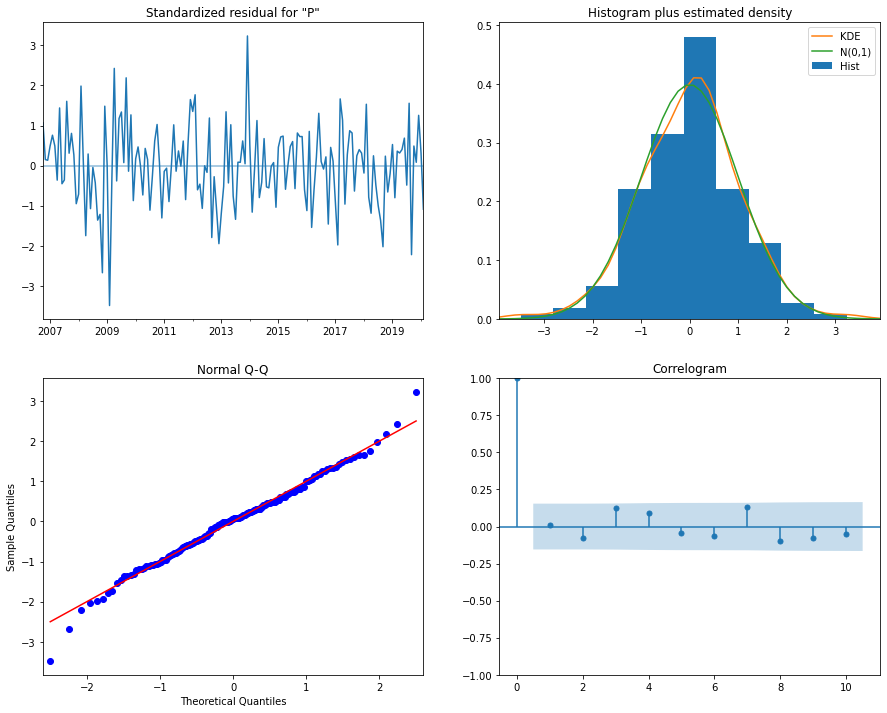

In [43]:
best_model.plot_diagnostics(figsize=(15, 12));


In [44]:
seas_prediction = best_model.get_prediction(full_results=True) #within-sample prediction
df_3['seas_predicted'] = seas_prediction.predicted_mean

In [45]:
seas_forecast = best_model.get_forecast(steps=6,full_results=True) #outside of sample forecast
seas_mean_forecast = seas_forecast.predicted_mean
fcast_dates = pd.date_range(start='2020-03-01', end='2020-08-01', freq='MS');

In [46]:
seas_mean_forecast

2020-03-01    14.657896
2020-04-01    14.648188
2020-05-01    14.736127
2020-06-01    14.845275
2020-07-01    14.830896
2020-08-01    14.863156
Freq: MS, Name: predicted_mean, dtype: float64

In [47]:
s_ci = seas_forecast.conf_int(alpha=0.05)

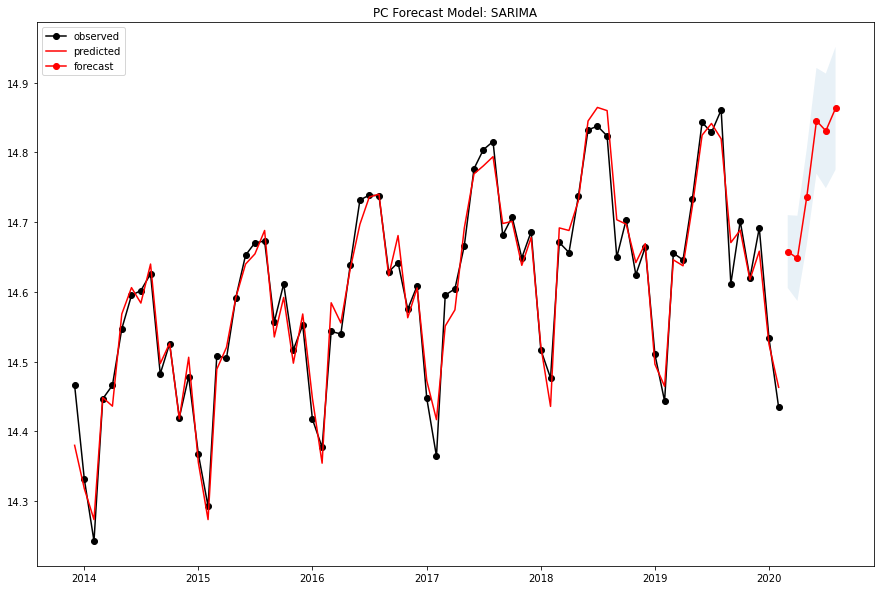

In [48]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(df_3['Passenger Count'].tail(75),color='black',marker="o",label='observed')
ax.plot(df_3['seas_predicted'].tail(75),color="red",label='predicted')
ax.plot(fcast_dates,seas_mean_forecast.values,color='red',marker="o",label='forecast')
ax.fill_between(seas_mean_forecast.index,s_ci.iloc[:, 0], s_ci.iloc[:, 1], alpha=0.1)

plt.tight_layout
plt.title("PC Forecast Model: SARIMA")
ax.legend(loc='upper left');

<div class="alert alert-block alert-warning">
The results of our best fit prediction shows what would be a good fit for Feb 2020 through Aug 2020 with out the pandemic hitting. When you compare it to the real data listed then you can definely see a difference.
</div>

In [49]:
dates = pd.date_range(start='2005-01-01', end='2020-01-01', freq='MS')    
# fcast_dates = pd.date_range(start='2021-01-01', end='2034-01-01', freq='MS')

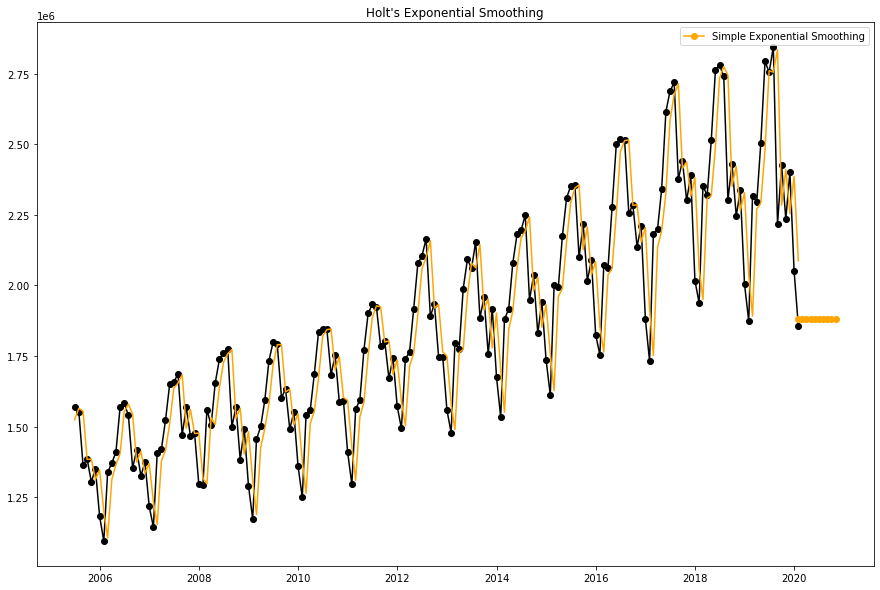

In [50]:
#models and predictions
model1 = SimpleExpSmoothing(counts,initialization_method="estimated").fit()

fcast1 = model1.forecast(10)

#plots
dates = pd.date_range(start='2005-07-01', end='2020-02-01', freq='MS')  
fcast_dates1 = pd.date_range(start='2020-02-01', end='2020-11-01', freq='MS');

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(dates,counts.loc['2005-01-01 00:00:00':], marker="o",color="black")

ax.plot(dates,model1.fittedvalues.loc['2005-01-01 00:00:00':],color="orange")
ax.plot(fcast_dates1,fcast1, marker="o", color="orange",label="Simple Exponential Smoothing")


plt.tight_layout
plt.title("Holt's Exponential Smoothing")
plt.legend();

In [51]:
#ignore bug warning 
warnings.filterwarnings('ignore')
#models and predictions

model2 = Holt(counts,initialization_method="estimated").fit()
fcast2 = model2.forecast(10)
model3 = Holt(counts,exponential=True, initialization_method="estimated").fit()
fcast3 = model3.forecast(10)
model4 = Holt(counts,damped_trend=True, initialization_method="estimated").fit()
fcast4 = model4.forecast(10)
model5 = Holt(counts,exponential=True, damped_trend=True, initialization_method="estimated").fit()
fcast5 = model5.forecast(10)

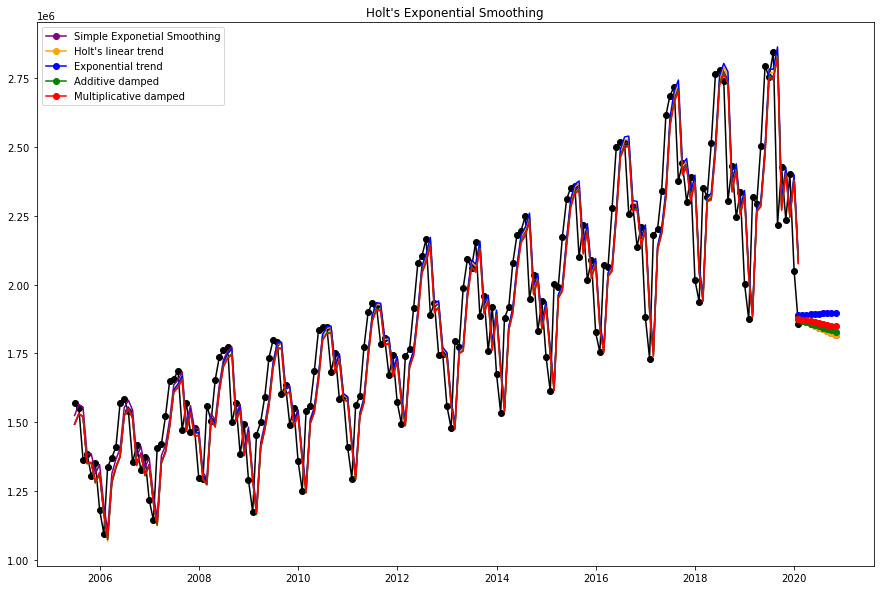

In [52]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(dates,counts.loc["2005":], marker="o",color="black")

ax.plot(dates,model1.fittedvalues.loc["2005":],color="purple")
ax.plot(fcast_dates1,fcast2, marker="o", color="purple",label="Simple Exponetial Smoothing")

ax.plot(dates,model2.fittedvalues.loc["2005":],color="orange")
ax.plot(fcast_dates1,fcast2, marker="o", color="orange",label="Holt's linear trend")

ax.plot(dates,model3.fittedvalues.loc["2005":],color="blue")
ax.plot(fcast_dates1,fcast3, marker="o",color="blue",label="Exponential trend")

ax.plot(dates,model4.fittedvalues.loc["2005":],color="green")
ax.plot(fcast_dates1,fcast4, marker="o", color="green",label="Additive damped")

ax.plot(dates,model5.fittedvalues.loc["2005":],color="red")
ax.plot(fcast_dates1,fcast5, marker="o", color="red",label="Multiplicative damped")

#plt.yticks(np.arange(40,75,step=5))
plt.tight_layout
plt.title("Holt's Exponential Smoothing")
plt.legend();

In [53]:
models = {'Simple Exponential Smoothing':model1,"Holt's linear":model2,'Exponential Trend':model3,'Additive Damped':model4,'Multiplicative Damped':model5}

In [54]:
for (key,val) in models.items():
    print(key)
    print('SSE: ',int(val.sse),'AIC: ',np.round(val.aic,2),'AICc: ',np.round(val.aicc,2),'BIC: ',np.round(val.bic,2),'\n')

Simple Exponential Smoothing
SSE:  5398615096276 AIC:  4253.82 AICc:  4254.05 BIC:  4260.16 

Holt's linear
SSE:  5539462241705 AIC:  4262.35 AICc:  4262.85 BIC:  4275.03 

Exponential Trend
SSE:  5548554866187 AIC:  4262.64 AICc:  4263.13 BIC:  4275.32 

Additive Damped
SSE:  5473779567023 AIC:  4262.25 AICc:  4262.92 BIC:  4278.1 

Multiplicative Damped
SSE:  5444023234101 AIC:  4261.29 AICc:  4261.96 BIC:  4277.14 



Residuals should be uncorrelated with zero mean, have constant variance and are approximately normally distributed.

** Mean of the residuals:  2280.1

** Ljung Box Test, p-value: 0.115 (>0.05, Uncorrelated)

** Sample too small for Jarque Bera Normality Test (< 2000)

** AD Fuller, p_value: 0.046 (<0.05, Stationary)


(<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>,
 <AxesSubplot:title={'center':'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'kde and pdf'}, ylabel='Density'>)

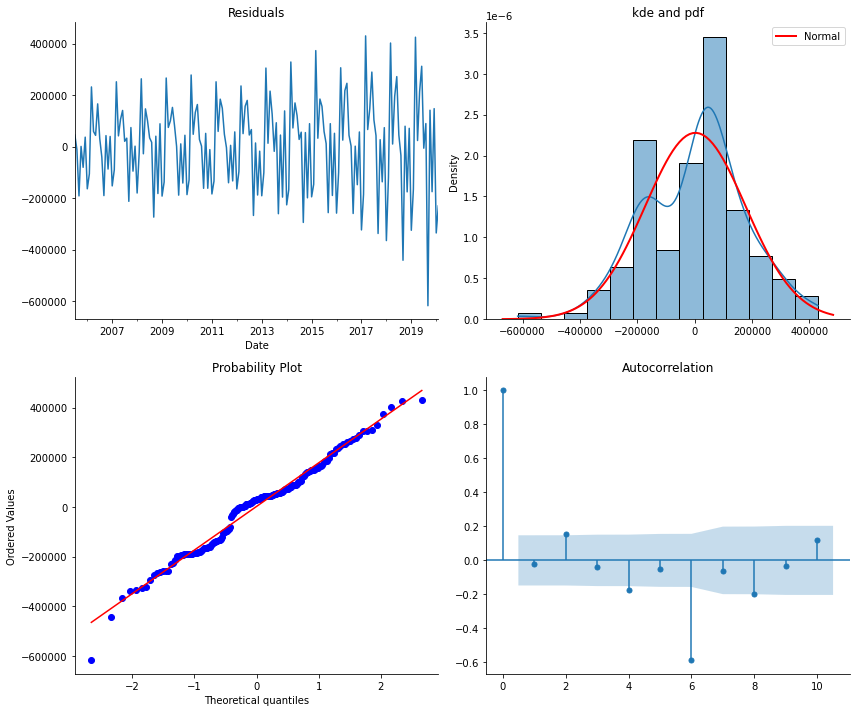

In [55]:
model1_resid = model1.resid

residcheck(model1_resid,lags=10)

<div class="alert alert-block alert-warning">
From our residual check we can see that our mean value is not zero which is good but compared to the other models, the mean isnt zero also not stationary etc.
</div>

In [56]:
passengers = df_3['Passenger Count']



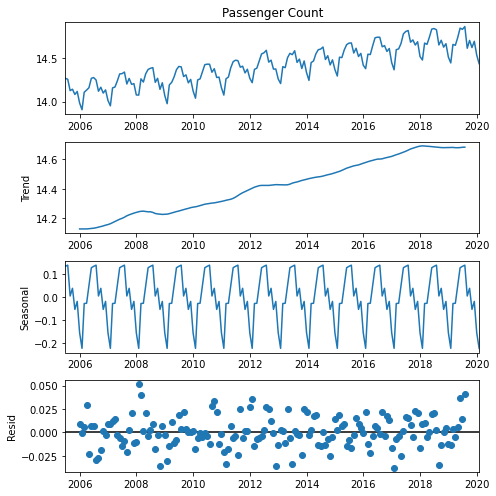

In [57]:
plt.rcParams["figure.figsize"] = [7,7]

decomp = seasonal_decompose(passengers, model='additive',period=12)
decomp.plot();

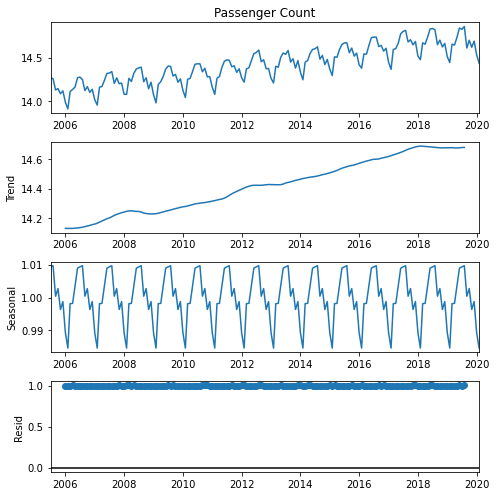

In [58]:
decomp = seasonal_decompose(passengers, model='multiplicative').plot();

In [59]:
fit1 = ExponentialSmoothing(passengers, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(passengers, seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(passengers, seasonal_periods=12, trend='mul', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(passengers, seasonal_periods=12, trend='mul', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()



In [60]:
models2 = {'Holt–Winters: add/add/d':fit1,'Holt–Winters: add/mul/d':fit2,'Holt–Winters: mul/add/d':fit3,'Holt–Winters: mul/mul/d':fit4}

for (key,val) in models2.items():
    print(key, ' SSE: ',int(val.sse),'AIC: ',np.round(val.aic,2),'AICc: ',np.round(val.aicc,2),'BIC: ',np.round(val.bic,2),'\n')

Holt–Winters: add/add/d  SSE:  0 AIC:  -1331.66 AICc:  -1326.79 BIC:  -1277.77 

Holt–Winters: add/mul/d  SSE:  0 AIC:  -1335.73 AICc:  -1330.86 BIC:  -1281.83 

Holt–Winters: mul/add/d  SSE:  0 AIC:  -1326.14 AICc:  -1321.26 BIC:  -1272.24 

Holt–Winters: mul/mul/d  SSE:  0 AIC:  -1335.78 AICc:  -1330.91 BIC:  -1281.88 



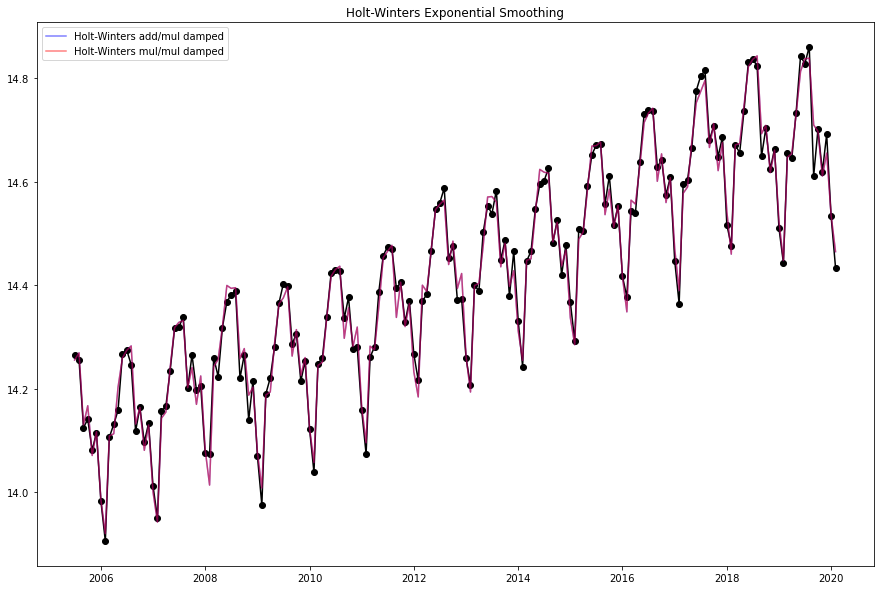

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(df_3.index,passengers, marker="o",color="black")
ax.plot(df_3.index,fit2.fittedvalues,color="blue", label = "Holt-Winters add/mul damped",alpha=.5)
ax.plot(df_3.index,fit4.fittedvalues,color="red", label = "Holt-Winters mul/mul damped",alpha=.5)


plt.tight_layout
plt.title("Holt-Winters Exponential Smoothing")
plt.legend();

Residuals should be uncorrelated with zero mean, have constant variance and are approximately normally distributed.

** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.36 (>0.05, Uncorrelated)

** Sample too small for Jarque Bera Normality Test (< 2000)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>,
 <AxesSubplot:title={'center':'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'kde and pdf'}, ylabel='Density'>)

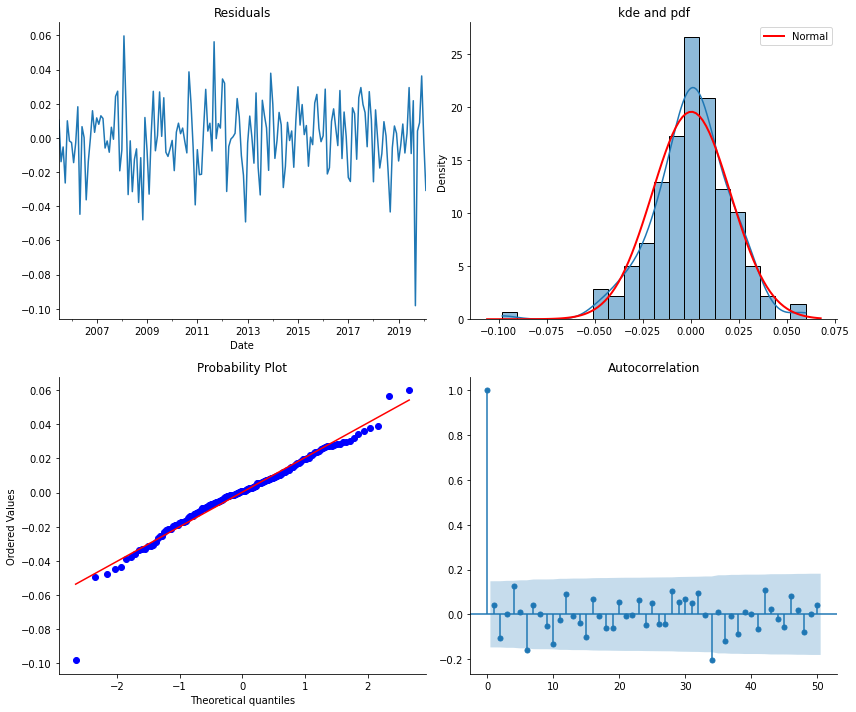

In [62]:
fit2_resid = fit2.resid
residcheck(fit2.resid, lags=50)

<div class="alert alert-block alert-warning">
As we continue I chose to test out the Holts-Winter(Triple Exponential Smoothing) which applies to seasonal data and compared to the other models, this model has the better fit. Our residual check shows that our mean is zero, uncorrelated and also our optional criteria which is that its stationary and has a constant variance.
</div>

In [63]:
df = pd.DataFrame(df_21.groupby("Date")["Passenger Count"].sum())

In [64]:
df["Passenger Count"] = np.log(df['Passenger Count'])

In [65]:
df

,Passenger Count
Date,
2005-07-01,14.266212
2005-08-01,14.255793
2005-09-01,14.125301
2005-10-01,14.141082
2005-11-01,14.081279
...,...
2020-02-01,14.434439
2020-03-01,13.745791
2020-04-01,11.130713


### 

In [66]:
fcast_1 = fit2.forecast(6)
fcast_1 #CHECK DATES

2020-03-01    14.651045
2020-04-01    14.653957
2020-05-01    14.734874
2020-06-01    14.815712
2020-07-01    14.824562
2020-08-01    14.830491
Freq: MS, dtype: float64

In [67]:
fcast_dates #CHECK DATES

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01'],
              dtype='datetime64[ns]', freq='MS')

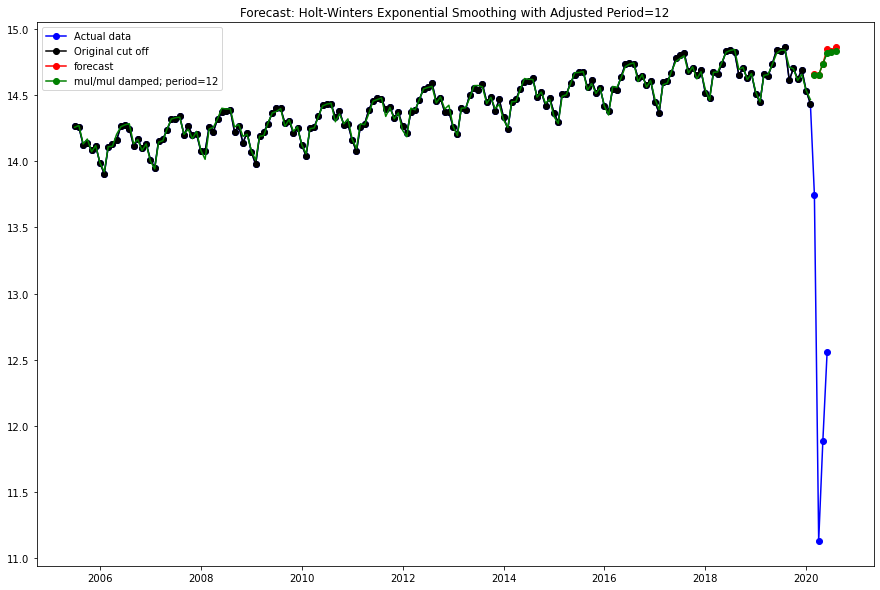

In [68]:

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df.index,df["Passenger Count"], marker="o",color="blue", label='Actual data')
ax.plot(df_3.index,passengers, marker="o",color="black", label='Original cut off')
ax.plot(dates,fit2.fittedvalues.loc["2005":],color="green")
ax.plot(fcast_dates,seas_mean_forecast.values,color='red',marker="o",label='forecast')
ax.plot(fcast_dates,fcast_1, marker="o", color="green",label="mul/mul damped; period=12")

#plt.yticks(np.arange(40,75,step=5))
plt.tight_layout
plt.title("Forecast: Holt-Winters Exponential Smoothing with Adjusted Period=12")
plt.legend();

<div class="alert alert-block alert-warning">
From the graph above we can see that the predicted passenger count was completely different from the actual.
</div>

In [69]:
df_f = pd.read_csv('air-travel2.csv')#add more code cells as necessary. comment your code well

In [70]:
df_f.head()

,Year,Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,2005,2005-07,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
1,2005,2005-07,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090
2,2005,2005-07,Air China,CA,Air China,CA,International,Asia,Enplaned,Other,International,G,5500
3,2005,2005-07,Air France,AF,Air France,AF,International,Europe,Enplaned,Other,International,A,11638
4,2005,2005-07,Air New Zealand,NZ,Air New Zealand,NZ,International,Australia / Oceania,Enplaned,Other,International,G,4962


In [71]:
df_f1 = df_f[["Date","Operating Airline","Passenger Count"]]

In [72]:
df_f1['Date']=pd.to_datetime(df_f1['Date']);df_f1.head()

,Date,Operating Airline,Passenger Count
0,2005-07-01,ATA Airlines,29131
1,2005-07-01,Air Canada,34090
2,2005-07-01,Air China,5500
3,2005-07-01,Air France,11638
4,2005-07-01,Air New Zealand,4962


In [73]:
df_f1

,Date,Operating Airline,Passenger Count
0,2005-07-01,ATA Airlines,29131
1,2005-07-01,Air Canada,34090
2,2005-07-01,Air China,5500
3,2005-07-01,Air France,11638
4,2005-07-01,Air New Zealand,4962
...,...,...,...
10593,2020-06-01,United Airlines,10522
10594,2020-06-01,United Airlines,50628
10595,2020-06-01,United Airlines,2991
10596,2020-06-01,United Airlines,1352


In [74]:
df5 = pd.DataFrame(df_f1.loc[df_f1["Date"]>="2020-03", "Operating Airline"])

In [75]:
df5

,Operating Airline
10441,ABC Aerolineas S.A. de C.V. dba Interjet
10442,Aer Lingus
10443,Aeromexico
10444,Air Canada
10445,Air China
...,...
10593,United Airlines
10594,United Airlines
10595,United Airlines
10596,United Airlines


In [76]:
dic0 = {}

for x in df5["Operating Airline"]:
	dic0[x] = dic0.get(x,0)+1
#print(dic0.values())

for x in dic0:
#print(x,dic0[x])
        
    types0 = []
    count0 = []

for x in dic0:
    types0.append(x)
    count0.append(dic0[x])

In [77]:
dic0

{'ABC Aerolineas S.A. de C.V. dba Interjet': 1,
 'Aer Lingus': 1,
 'Aeromexico': 2,
 'Air Canada': 4,
 'Air China': 2,
 'Air France': 1,
 'Air India Limited': 3,
 'Air New Zealand': 1,
 'Air Pacific Limited dba Fiji Airways': 1,
 'Alaska Airlines': 7,
 'All Nippon Airways': 3,
 'American Airlines': 7,
 'British Airways': 3,
 'COPA Airlines, Inc.': 1,
 'Cathay Pacific': 2,
 'China Airlines': 2,
 'China Southern': 2,
 'Compass Airlines': 3,
 'Delta Air Lines': 4,
 'EVA Airways': 4,
 'El Al Israel Airlines LTD.': 1,
 'Emirates': 1,
 'French Bee': 3,
 'Frontier Airlines': 4,
 'Hawaiian Airlines': 4,
 'Horizon Air': 4,
 'Iberia': 1,
 'Japan Airlines': 2,
 'Jazz Aviation': 2,
 'JetBlue Airways': 4,
 'KLM Royal Dutch Airlines': 1,
 'Korean Air Lines': 4,
 'Lufthansa German Airlines': 2,
 'Norwegian Air Shuttle ASA': 1,
 'Norwegian Air UK Ltd': 1,
 'Philippine Airlines': 3,
 'Qantas Airways': 1,
 'SAS Airlines': 1,
 'Singapore Airlines': 1,
 'SkyWest Airlines': 12,
 'Southwest Airlines': 4,
 '

In [78]:
box = list(zip(types0,count0))

In [79]:
max(dic0 , key=dic0.get)

'United Airlines'

In [80]:
sum(count0) / len(count0) # mean total flights from each airline from 

3.0784313725490198

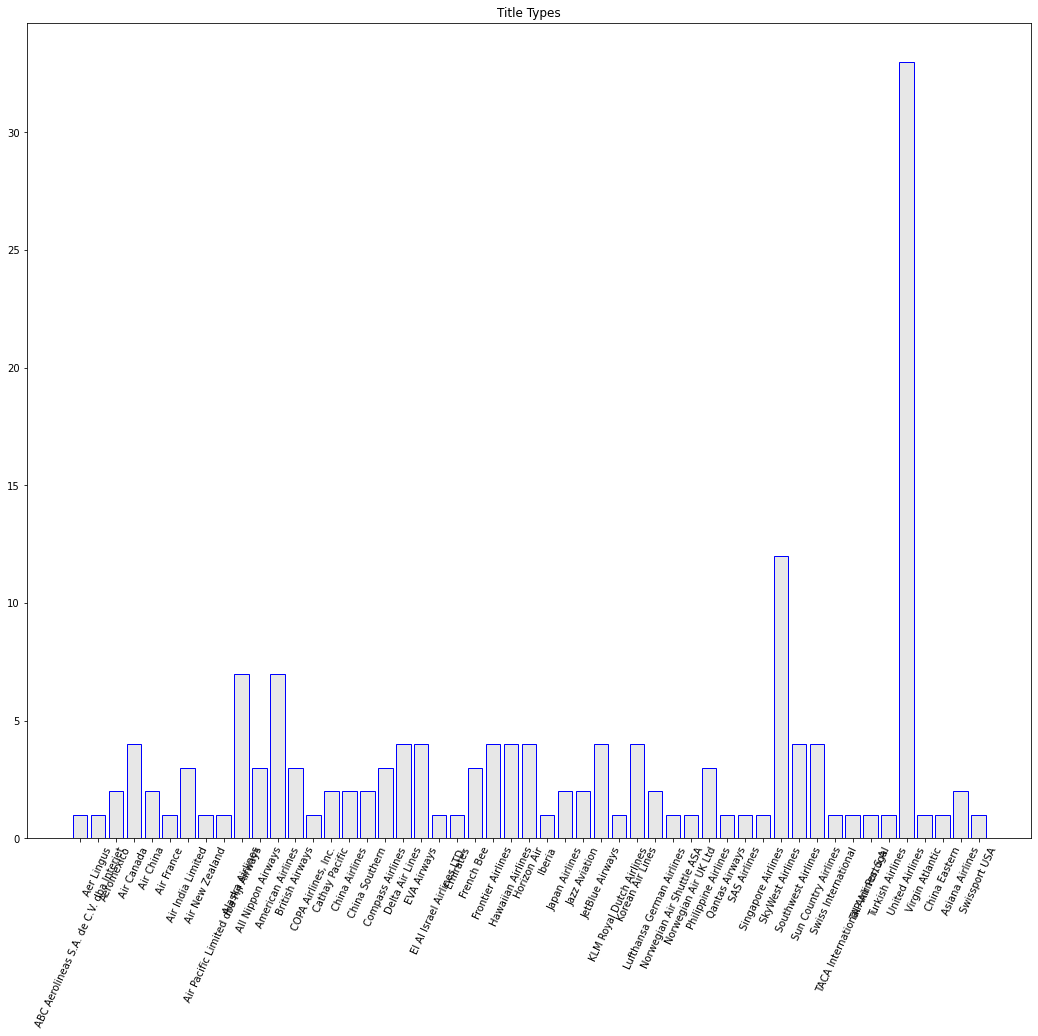

In [81]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,15))


# create a dataset
height = count0
bars = types0
x_pos = np.arange(len(bars))

# Create bars with blue edge color
plt.bar(x_pos, height, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.xticks(rotation=65)
plt.title("Title Types")
# Show graph
plt.show()

<div class="alert alert-block alert-warning">
With this portion I chose to visualize and see which airlines were the most active after the pandemic. In the code above I grouped up Date,Operating Airline, and Passenger Count. As I continued I found out that over 157 flights record on or after March 2020. So after seeing this information I chose to see which Airlines flew the most. I found out through my analysis that United Airlines had the most flights between March 2020 and June 2020. They had 33 flights when the mean average of flights were 3 flights.
</div>

<div class="alert alert-block alert-warning">
The Pandemic data vs the Predicted data shows us how things were on the rise as usual traffic was in airlines vs when something severe happens such as deadly disease. The model used to predict gave off nice visuals for anyone who would seek to view the graphing. We also at the end found out that United airlines has a huge outliing number of flights after most Airlines shut down.
</div>